# Data Augmentation with Oversampling methods on Imbalanced Text Dataset for Korean Vishing Classification

In [1]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# If CUDA is available, print the current GPU details
if torch.cuda.is_available():
    print("Current GPU Index:", torch.cuda.current_device())
    print("Current GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
    print("GPU Memory Allocated:", torch.cuda.memory_allocated())
    print("GPU Memory Cached:", torch.cuda.memory_reserved())

CUDA Available: True
Current GPU Index: 0
Current GPU Name: NVIDIA GeForce RTX 3050
GPU Memory Allocated: 0
GPU Memory Cached: 0


In [2]:
# https://ruslanmv.com/blog/How-to-handle-imbalanced-text-data-in-Natural-Language-Processing
#

#importing necessary libraries
# General
from time import time
from timeit import default_timer as timer
import numpy as np
import pandas as pd
import re
import os
import io
import pickle
import sys
import subprocess
from collections import Counter

# EDA
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px
from wordcloud import WordCloud
from collections import Counter
9089
# NLP 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize 

# ML
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_auc_score, matthews_corrcoef, cohen_kappa_score

# Dataset analysis

In [3]:
# import the dataset
print('Loading data...')
dataset = pd.read_csv('KorCCVi_v2.csv')
dataset.info()
dataset.head()
# print(dataset.shape)
# print(dataset)

Loading data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2927 entries, 0 to 2926
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          2927 non-null   int64  
 1   transcript  2927 non-null   object 
 2   confidence  0 non-null      float64
 3   label       2927 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 91.6+ KB


,id,transcript,confidence,label
0,0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,NaN,0
1,1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,NaN,0
2,2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,NaN,0
3,3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,NaN,0
4,4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,NaN,0


<Axes: >

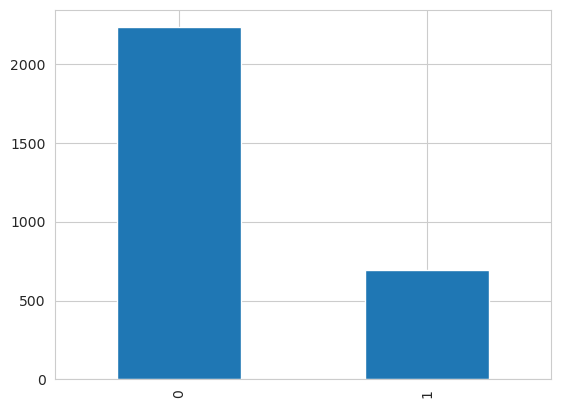

In [4]:
dataset['label'].value_counts(dropna=False).plot(kind='bar')

In [5]:
dataset.describe()

,id,confidence,label
count,2927.000000,0.0,2927.000000
mean,1463.000000,NaN,0.237444
std,845.096444,NaN,0.425590
min,0.000000,NaN,0.000000
25%,731.500000,NaN,0.000000
50%,1463.000000,NaN,0.000000
75%,2194.500000,NaN,0.000000
max,2926.000000,NaN,1.000000


In [6]:
#checking for null values
dataset.isnull().sum()

id               0
transcript       0
confidence    2927
label            0
dtype: int64

In [7]:
# drop the colum we don't need
dataset.drop(['confidence', 'id'], axis=1, inplace=True)
dataset

,transcript,label
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0
...,...,...
2922,지금까지 사실확인서를 연락드렸습니다. 하고 있는데 이런 사건 때문에 내가 여쭤볼게 ...,1
2923,연료 데이는 사건 때문에 연락 드렸는데 혹시 김명철씨 가십니까 모르시고 아는 사람도...,1
2924,4장 4절 일어났습니까? 장소 잡고 님께서는 42세 남성 김동술 알고 계십니까? 아...,1
2925,네\n네 여보세요\n뭐 어디세요?\n아 네 안녕하세요 저희 그 하나캐피탈에서 연락을...,1


## Calculating the length of each data sample.

In [8]:
dataset['length'] = dataset['transcript'].apply(lambda x: len(x))
dataset.head()

,transcript,label,length
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0,5773
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0,5126
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0,4970
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0,5480
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0,4141


## Distribution based on length of words

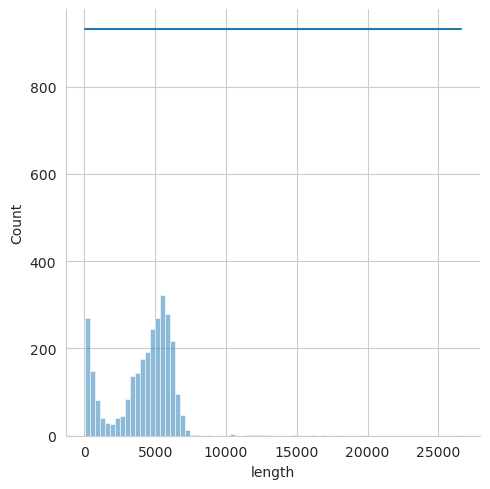

In [9]:
sns.displot(dataset['length'], kde=True)

<Axes: xlabel='label', ylabel='length'>

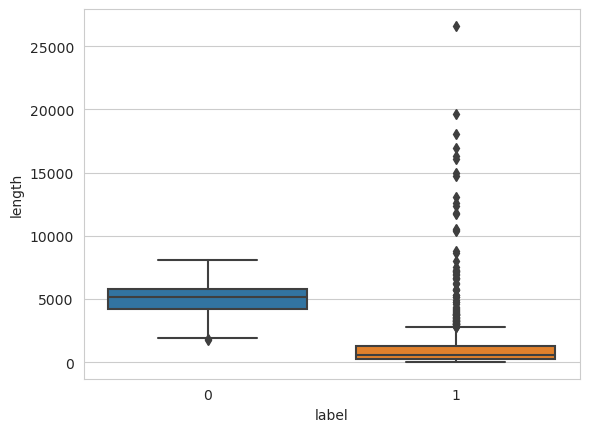

In [10]:
sns.boxplot(y='length', x='label', data=dataset)

In [11]:
dataset.head()

,transcript,label,length
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0,5773
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0,5126
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0,4970
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0,5480
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0,4141


# Morphology Analyzer Installation

## Installation of Mecab-ko-for-GoogleColab

In [12]:
# try:
#     from konlpy.tag import Mecab
#     mecab = Mecab()
#     text = '그중에서 제일 기 좋았던 거는 스페인이랑 포르투갈이었거든요.'
#     my_morphs = mecab.morphs(text)
#     print(my_morphs)
#     print('--- The Mecab module is installed ---')
# except NameError:
#     print('--- The Mecab module is NOT installed ---')

#     # install Mecab module
#     # python = sys.executable
#     # subprocess.check_call(
#         # [python, '-m', 'pip', 'install', 'mecab-ko'],
#         # stdout=subprocess.DEVNULL
#     # )
#     !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
#     !cd Mecab-ko-for-Google-Colab
#     !bash install_mecab-ko_on_colab_light_220429.sh
    
#     # !sudo apt-get install curl git
#     # !bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
# finally:
#     # import from konlpy.tag import Mecab
#     print('--- Finally ---')
#     # from konlpy.tag import Mecab
#     # mecab = Mecab()
#     # text = '그중에서 제일 기 좋았던 거는 스페인이랑 포르투갈이었거든요.'
#     # my_morphs = mecab.morphs(text)
#     # print(my_morphs)


In [13]:
# !git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git

In [14]:
# cd Mecab-ko-for-Google-Colab

In [15]:
# !bash install_mecab-ko_on_colab_light_220111.sh
# !bash install_mecab-ko_on_colab_light_220429.sh

## Testing MeCab

In [16]:
from konlpy.tag import Mecab
mecab = Mecab()
text = '그중에서 제일 기 좋았던 거는 스페인이랑 포르투갈이었거든요.'
my_morphs = mecab.morphs(text)
print(my_morphs)

['그', '중', '에서', '제', '일', '기', '좋', '았', '던', '거', '는', '스페인', '이랑', '포르투갈', '이', '었', '거든요', '.']


In [17]:
mecab.pos(text)

[('그', 'MM'),
 ('중', 'NNB'),
 ('에서', 'JKB'),
 ('제', 'XPN'),
 ('일', 'NR'),
 ('기', 'NNBC'),
 ('좋', 'VA'),
 ('았', 'EP'),
 ('던', 'ETM'),
 ('거', 'NNB'),
 ('는', 'JX'),
 ('스페인', 'NNP'),
 ('이랑', 'JC'),
 ('포르투갈', 'NNP'),
 ('이', 'VCP'),
 ('었', 'EP'),
 ('거든요', 'EF'),
 ('.', 'SF')]

# Dataset Preprocessing

## Dataset cleaning and purification

In [18]:
# function to perform the cleaning parts
def apply_replacement(src_df, replace_func):
    ret_df = src_df
    ret_df['transcript'] = ret_df['transcript'].apply(lambda x: replace_func(x))
    return ret_df

# remove the unwanted word and characters from the dataset
def word_replace(x):
    example_word_replace_list = {'o/': '',
                                 'b/': '',
                                 'n/': '',
                                 '\n': ' ',
                                 'name': '',
                                 'laughing': '',
                                 'clearing': '',
                                 'singing': '',
                                 'applauding': ''}
    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

# remove the special character from the transcripts
def remove_special_sysmbols(sentence): 
    sentence = re.sub(r"[-~=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]", '', sentence)
    return sentence

# remove x and O from the transcripts
def replace_x_o(sentence):
    
    # sentence = re.sub(r"(o{2,})|(O{2,})|(\ㅇ{2,})|(0{2,})|(x{2,})", '' , sentence)
    # sentence = re.sub(r"x{2,}", '' , sentence)
    # sentence = re.sub(r"0{2,}", '' , sentence)
    # sentence = re.sub(r"ㅇ{2,}", '' , sentence)
    # sentence = re.sub(r"O{2,}", '' , sentence)
    # sentence = re.sub(r"o{2,}", '' , sentence)
    sentence = re.sub(r"(o|O|\ㅇ|0|x){2,}", '' , sentence)
    return sentence

# remove the unwanted word and characters from the transcripts
def nline_replace(x):
    example_word_replace_list = {'\n' : ' '}
    for i in example_word_replace_list:
        x = x.replace(i, example_word_replace_list[i])
    return x

# remove extra whote space
def remove_extra_white_spaces(text):
    single_char_pattern = r'\s+[a-zA-Z]\s+'
    without_sc = re.sub(pattern=single_char_pattern, repl=" ", string=text)
    return without_sc

In [19]:
dataset['transcript_clean'] = dataset['transcript'].apply(lambda x: word_replace(x))

In [20]:
dataset['transcript_clean'] = dataset['transcript_clean'].apply(lambda x: remove_special_sysmbols(x))

In [21]:
dataset['transcript_clean'] = dataset['transcript_clean'].apply(lambda x: replace_x_o(x))

In [22]:
dataset['transcript_clean'] = dataset['transcript_clean'].apply(lambda x: nline_replace(x))

In [23]:
dataset['transcript_clean'] = dataset['transcript_clean'].apply(lambda x: remove_extra_white_spaces(x))

In [24]:
dataset['length_transcript_clean'] = dataset['transcript_clean'].apply(lambda x: len(x))

In [25]:
dataset

,transcript,label,length,transcript_clean,length_transcript_clean
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0,5773,저는 여행 다니는 것을 굉장히 좋아하는데요 그래가지고 스페인이나 뭐 영국 유럽 아니...,5629
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0,5126,반려동물을 키우고 계신가요 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보고...,5024
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0,4970,씨는 주로 어떤 음식 좋아하시나요 저는 근데 가리는 게 거의 없어서 대부분 다 잘...,4877
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0,5480,씨는 반려동물 어 좋 뭐 어떤 동물 좋아하세요 저는 고양이를 정말 좋아하는데요 정...,5383
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0,4141,가장 좋아하는 음식이 무엇인가요 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고 ...,4057
...,...,...,...,...,...
2922,지금까지 사실확인서를 연락드렸습니다. 하고 있는데 이런 사건 때문에 내가 여쭤볼게 ...,1,825,지금까지 사실확인서를 연락드렸습니다 하고 있는데 이런 사건 때문에 내가 여쭤볼게 있...,801
2923,연료 데이는 사건 때문에 연락 드렸는데 혹시 김명철씨 가십니까 모르시고 아는 사람도...,1,659,연료 데이는 사건 때문에 연락 드렸는데 혹시 김명철씨 가십니까 모르시고 아는 사람도...,651
2924,4장 4절 일어났습니까? 장소 잡고 님께서는 42세 남성 김동술 알고 계십니까? 아...,1,1711,4장 4절 일어났습니까 장소 잡고 님께서는 42세 남성 김동술 알고 계십니까 아니요...,1669
2925,네\n네 여보세요\n뭐 어디세요?\n아 네 안녕하세요 저희 그 하나캐피탈에서 연락을...,1,432,네 네 여보세요 뭐 어디세요 아 네 안녕하세요 저희 그 하나캐피탈에서 연락을 드렸습...,424


In [26]:
# Save the cleansed dataset
dataset.to_csv("KorCCVi_v2_cleaned_1.csv")

## Remove the Korean stop words

In [27]:
# from pandas import DataFrame 
# transcript_clean=DataFrame(dataset['transcript_clean'])

In [28]:
# transcript_clean
dataset.head()

,transcript,label,length,transcript_clean,length_transcript_clean
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0,5773,저는 여행 다니는 것을 굉장히 좋아하는데요 그래가지고 스페인이나 뭐 영국 유럽 아니...,5629
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0,5126,반려동물을 키우고 계신가요 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보고...,5024
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0,4970,씨는 주로 어떤 음식 좋아하시나요 저는 근데 가리는 게 거의 없어서 대부분 다 잘...,4877
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0,5480,씨는 반려동물 어 좋 뭐 어떤 동물 좋아하세요 저는 고양이를 정말 좋아하는데요 정...,5383
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0,4141,가장 좋아하는 음식이 무엇인가요 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고 ...,4057


In [29]:
from konlpy.tag import Mecab
mecab = Mecab()

transcript_clean_doc = [(mecab.morphs(x)) for x in dataset['transcript_clean']]

In [30]:
## remove the stop word
stopwords = ["을", "를", "이", "가", "ㅡ", "은", "는", "XXX", "xxx", "어요", "아니", "입니다", "에서", "니까", "으로",
             "근데", "습니다", "습니까", "저희", "합니다", "하고", "싶어요", "있는", "있습니다", "싶습니다", "그냥",
             "고요", "에요", "예요", "으시", "그래서"]

# open and read the file containing comprehenisive stopwords 
# stopwords_all = open("stopwords-ko.txt").readlines()

# function to remove the stop word from the train and test dataframe
def get_model_input(_words):
    global stopwords
    _words = [x for x in _words if x[0] not in stopwords]
    _words = [x for x in _words if x[:-1] not in stopwords]

    for i in range(len(_words)-1):
        yield _words[i]

In [31]:
def get_corpus(df):
    corpus = []
    for lwords in df:    
        temp = []
        for x in get_model_input(lwords):
            if len(x) != 1:
                temp.append("{}".format(x))
        corpus.append(" ".join(temp))
    return corpus        

In [32]:
corpus = get_corpus(transcript_clean_doc)

In [33]:
#adding new columnto datafram
dataset['corpus'] = corpus
dataset.head()

,transcript,label,length,transcript_clean,length_transcript_clean,corpus
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0,5773,저는 여행 다니는 것을 굉장히 좋아하는데요 그래가지고 스페인이나 뭐 영국 유럽 아니...,5629,여행 다니 굉장히 그래 스페인 영국 유럽 아니 국내 에서 강릉 전주 많이 다녔 혹시...
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0,5126,반려동물을 키우고 계신가요 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보고...,5024,반려 동물 키우 계신가요 혹시 키우 계시 다면은 어떤 반려 동물 한번 키워 생각 으...
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0,4970,씨는 주로 어떤 음식 좋아하시나요 저는 근데 가리는 게 거의 없어서 대부분 다 잘...,4877,주로 어떤 음식 나요 근데 거의 어서 대부분 인데 중식 평소 너무 기름진 니까 매운...
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0,5480,씨는 반려동물 어 좋 뭐 어떤 동물 좋아하세요 저는 고양이를 정말 좋아하는데요 정...,5383,반려 동물 어떤 동물 세요 고양이 정말 정말 사랑 정도 진짜 유튜브 항상 고양이 채...
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0,4141,가장 좋아하는 음식이 무엇인가요 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고 ...,4057,음식 무엇 인가요 주로 좋아해서 음식 매운 음식 특히 합니다 그래서 떡볶이 카레 매...


In [34]:
#adding new column
dataset['corpus'] = corpus
dataset.head()

,transcript,label,length,transcript_clean,length_transcript_clean,corpus
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0,5773,저는 여행 다니는 것을 굉장히 좋아하는데요 그래가지고 스페인이나 뭐 영국 유럽 아니...,5629,여행 다니 굉장히 그래 스페인 영국 유럽 아니 국내 에서 강릉 전주 많이 다녔 혹시...
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0,5126,반려동물을 키우고 계신가요 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보고...,5024,반려 동물 키우 계신가요 혹시 키우 계시 다면은 어떤 반려 동물 한번 키워 생각 으...
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0,4970,씨는 주로 어떤 음식 좋아하시나요 저는 근데 가리는 게 거의 없어서 대부분 다 잘...,4877,주로 어떤 음식 나요 근데 거의 어서 대부분 인데 중식 평소 너무 기름진 니까 매운...
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0,5480,씨는 반려동물 어 좋 뭐 어떤 동물 좋아하세요 저는 고양이를 정말 좋아하는데요 정...,5383,반려 동물 어떤 동물 세요 고양이 정말 정말 사랑 정도 진짜 유튜브 항상 고양이 채...
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0,4141,가장 좋아하는 음식이 무엇인가요 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고 ...,4057,음식 무엇 인가요 주로 좋아해서 음식 매운 음식 특히 합니다 그래서 떡볶이 카레 매...


In [35]:
dataset['length_corpus'] = dataset['corpus'].apply(lambda x: len(x))
dataset.head()

,transcript,label,length,transcript_clean,length_transcript_clean,corpus,length_corpus
0,저는 여행 다니는 것을 굉장히 좋아하는데요. 그래가지고 스페인이나 뭐 영국 유럽 아...,0,5773,저는 여행 다니는 것을 굉장히 좋아하는데요 그래가지고 스페인이나 뭐 영국 유럽 아니...,5629,여행 다니 굉장히 그래 스페인 영국 유럽 아니 국내 에서 강릉 전주 많이 다녔 혹시...,3388
1,반려동물을 키우고 계신가요? 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보...,0,5126,반려동물을 키우고 계신가요 혹시 안 키우고 계시다면은 어떤 반려동물을 한번 키워보고...,5024,반려 동물 키우 계신가요 혹시 키우 계시 다면은 어떤 반려 동물 한번 키워 생각 으...,3087
2,씨는 주로 어떤 음식 좋아하시나요? 저는 근데 가리는 게 거의 없어서 대부분 다 ...,0,4970,씨는 주로 어떤 음식 좋아하시나요 저는 근데 가리는 게 거의 없어서 대부분 다 잘...,4877,주로 어떤 음식 나요 근데 거의 어서 대부분 인데 중식 평소 너무 기름진 니까 매운...,2836
3,씨는 반려동물 어~ 좋 뭐 어떤 동물 좋아하세요? 저는 고양이를 정말 좋아하는데요...,0,5480,씨는 반려동물 어 좋 뭐 어떤 동물 좋아하세요 저는 고양이를 정말 좋아하는데요 정...,5383,반려 동물 어떤 동물 세요 고양이 정말 정말 사랑 정도 진짜 유튜브 항상 고양이 채...,2998
4,가장 좋아하는 음식이 무엇인가요? 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고...,0,4141,가장 좋아하는 음식이 무엇인가요 저는 주로 먹는 거를 좋아해서 음식을 가리지 않고 ...,4057,음식 무엇 인가요 주로 좋아해서 음식 매운 음식 특히 합니다 그래서 떡볶이 카레 매...,2304


In [36]:
# Save the final cleansed dataset
dataset.to_csv("KorCCVi_v2_cleaned_2.csv")

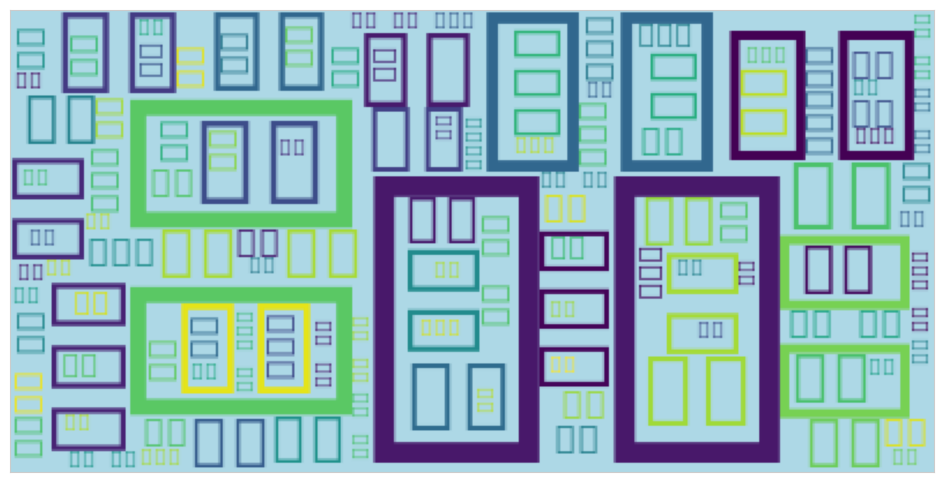

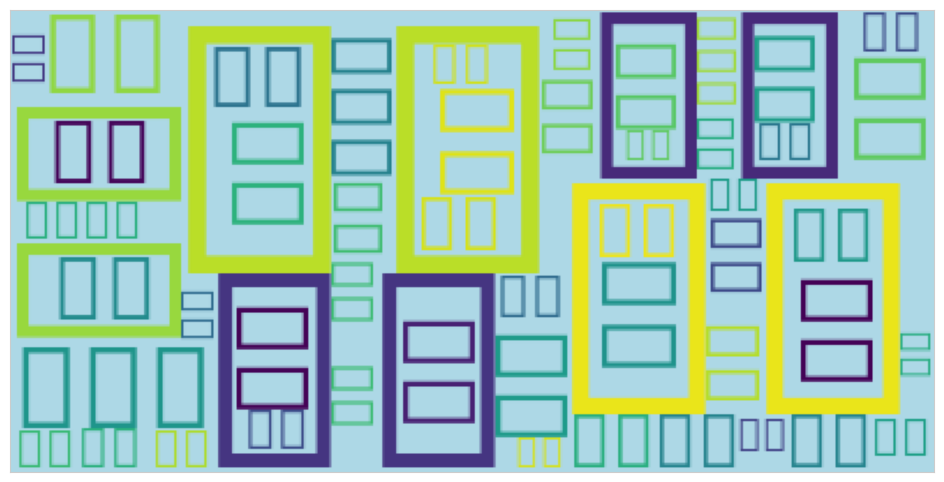

In [37]:
# wordcloud =False
plt.figure(figsize = (24, 6))
wc = WordCloud(min_font_size = 10, background_color = 'lightblue')
spam_wc = wc.generate(dataset[dataset['label'] == 1]['corpus'].str.cat(sep = " "))
plt.xticks([])
plt.yticks([])
plt.imshow(spam_wc)

plt.figure(figsize = (24, 6))
wc = WordCloud(min_font_size = 10, background_color = 'lightblue')
ham_wc = wc.generate(dataset[dataset['label'] == 0]['corpus'].str.cat(sep = " "))
plt.xticks([])
plt.yticks([])
plt.imshow(ham_wc);

In [38]:
def plot_class_distribution(data, title):
    sns.set(style="darkgrid")
    ax = sns.countplot(x='label', data=data)
    ax.set_title(title)
    
    # Annotate the bars with the number of samples
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='baseline', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
    plt.show()

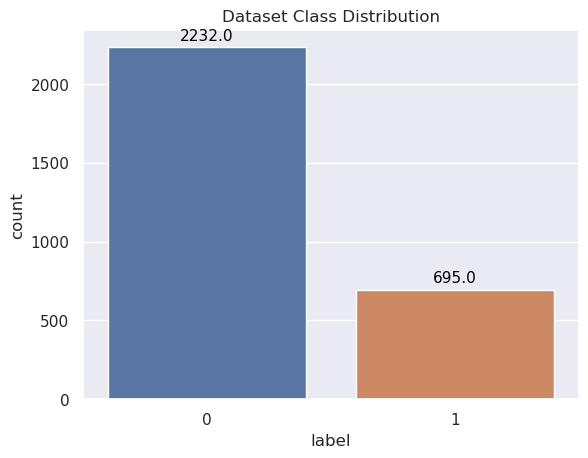

In [39]:
plot_class_distribution(dataset, 'Dataset Class Distribution')

# Split Dataset in train and test

In [40]:
def split_plot_dataset(dataset):
    # Sliptting dataframe into train and test dataframe
    df_train, df_test = train_test_split(dataset, test_size=0.15, random_state=42, shuffle=True)

    # slip the train set and reseve 20% of the data for the evaluation
    df_train, df_validation = train_test_split(df_train, test_size=0.15, random_state=42, shuffle=True)
    
    plot_class_distribution(df_train, 'Trainset Class Distribution')
    plot_class_distribution(df_validation, 'Validation Class Distribution')
    plot_class_distribution(df_test, 'Testset Class Distribution')
    
    return df_train, df_test, df_validation

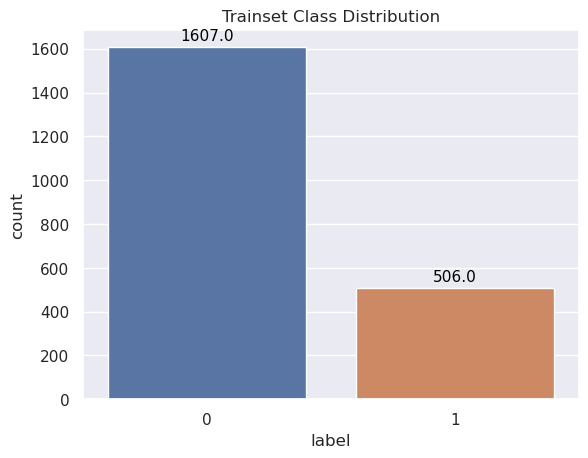

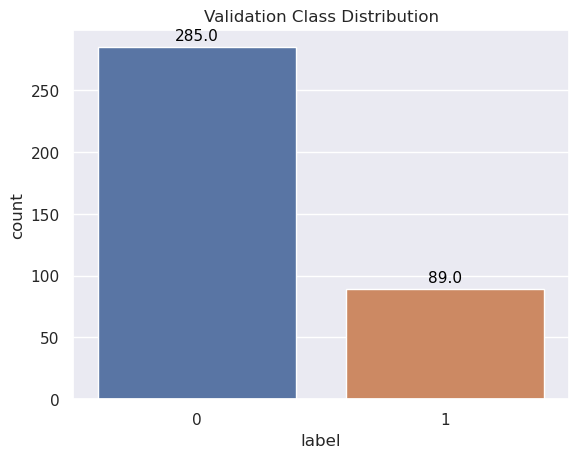

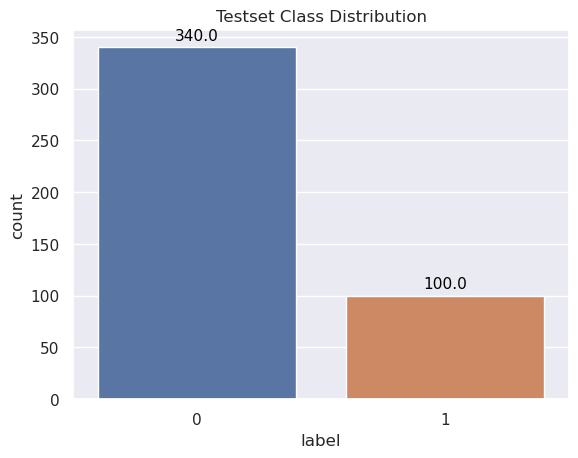

In [41]:
df_train, df_test, df_validation = split_plot_dataset(dataset)

# Vectorization of the dataset

## TF-IDF - Vectorized by weighting with TF-IDF

In [42]:
def vectorize_dataset(df_train, df_test, df_validation):
    # Convert a collection of raw documents to a matrix of TF-IDF features.
    tfidf = TfidfVectorizer(# analyzer='word', # default='word'
                            ngram_range=(1, 3), #(2, 6), # 3,6
                            max_df=0.5, #ignoring terms that have a document frequency higher than 0.5
                            # min_df=2, # 10
                            max_features=2000, #300, 500, 10000 (thsi will limit the vocavulary)
                            sublinear_tf=True, #replaces tf with 1 + log(tf), twenty occurrences of a term in a document
                                                #does not represent twenty times the significance of a single occurrence
                            use_idf=True
    )

    # tfidf = TfidfVectorizer()    
    
    X_train = tfidf.fit_transform(df_train['corpus']).toarray()
    X_validation = tfidf.fit_transform(df_validation['corpus']).toarray()
    X_test = tfidf.transform(df_test['corpus']).toarray()

    #Converting the sparse matrix into an array
    #We then apply the toarray function to convert the sparse matrix into an array.
    # X_train = X_train.toarray()
    # X_validation = X_validation.toarray()
    # X_test = X_test.toarray()

    y_train, y_validation, y_test = df_train['label'], df_validation['label'], df_test['label']
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [43]:
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(df_train, df_test, df_validation)

#set the evaluation set for early stop models
eval_set = [(X_validation, y_validation)]

# Training ML models with imballanced dataset

In [44]:
def get_metrics(y_test, y_test_pred, y_test_proba, threshold=0.5):
    # y_pred_class = y_test_proba > threshold
    y_pred_class = y_test_pred

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()

    true_positive_rate = tp / (tp + fn)
    true_negative_rate = tn / (tn + fp)
    positive_predictive_value = tp / (tp + fp)
    negative_predictive_value = tn / (tn + fn)
    false_positive_rate = fp / (fp + tn)
    false_negative_rate = fn / (tp + fn)
    false_discovery_rate = fp / (tp + fp)

    scores = {'Accuracy': accuracy_score(y_test, y_pred_class),
              'Precision': precision_score(y_test, y_pred_class),
              'Recall': recall_score(y_test, y_pred_class),
              'F1_score': f1_score(y_test, y_pred_class),
              'F05_score': fbeta_score(y_test, y_pred_class, beta=0.5),
              'F2_score': fbeta_score(y_test, y_pred_class, beta=2),
              'Roc auc score': roc_auc_score(y_test, y_test_proba),
              'Matthews_corrcoef': matthews_corrcoef(y_test, y_pred_class),
              'Cohen_kappa': cohen_kappa_score(y_test, y_pred_class),
              'True_positive_rate': true_positive_rate,
              'True_negative_rate': true_negative_rate,
              'Positive_predictive_value': positive_predictive_value,
              'Negative_predictive_value': negative_predictive_value,
              'False_positive_rate': false_positive_rate,
              'False_negative_rate': false_negative_rate,
              'False_discovery_rate': false_discovery_rate,
              }

    return scores

In [45]:
# # Setting up our results dataframe
# df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'ROC AUC', 'Accuracy', 'Training time', 'Test time'])
# df_results

## Defining the models

In [46]:
def define_models():
    models = [] #list to save the initiated models
    
#     # Gaussian Naive Bayes
#     # gnb assumes them to be continuous
#     gnb = GaussianNB()

#     # Mltinomial Naive Bayes
#     # nb assumes the features are discrete
#     mnb = MultinomialNB()

#     #logistic regression
#     lr = LogisticRegression(
#         # C=10,# random_state=1234
#     )

#     #Decision Tree
    dt = DecisionTreeClassifier(
        # max_depth=10, 
        # random_state=1234
    )

    #Random Forest
    rf = RandomForestClassifier(
        # n_estimators=100,
        # max_depth=20,
        # max_features=0.06,
        # n_jobs=6,
        # random_state=1234
    )

    #XGBoost
    xgb = XGBClassifier(
        early_stopping_rounds=10,
        verbosity=2,
        # n_estimators=2000,
        # tree_method='hist',
        # subsample=0.67,
        # colsample_level=0.06,
        # n_jobs=6,
        # random_state=1234
    )

    #LightGBM
    lgbm = LGBMClassifier(
        early_stopping_rounds=10,
        verbosity=2,
        # boost_from_average=False
        # num_leaves=64,
        # n_estimators=2000,
        # feature_fraction=0.06,
        # bagging_fraction=0.67,
        # bagging_freq=1,
        # n_jobs=6,
        # random_state=1234
    )
    
    #add the models in the list
    models = [dt, rf, xgb, lgbm]
    
    # #to specify which of our models require early stopping within the .fit() method.
    es_models = ['XGBClassifier', 'LGBMClassifier']
    
    return models, es_models

In [47]:
#Comparing our Competitors
# models = [gnb, mnb, lr, dt, rf, xgb, lgbm]
# models = [rf, xgb, lgbm, cb]
# model_names = [i.__class__.__name__ for i in models]
# classes_labels = np.arange(2)

# #define the models
# models, es_models = define_models()

## Train models

In [48]:
# Setting up our results dataframe
df_results = pd.DataFrame(columns=['F1_score', 'Precision', 'Recall', 'ROC AUC', 'Accuracy', 'Training time', 'Test time'])
# print(df_results)

In [49]:
# https://github.com/prateeksawhney97/MNIST-Classification-Multinomial-vs-Gaussian-Naive-Bayes/blob/master/MNIST%20Classification.ipynb

import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [50]:
def train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling=None):   
    #retrievce the models' name
    model_names = [i.__class__.__name__ for i in models]
    #set the number of classes for the confusion matrix
    classes_labels = np.arange(2)
    #name for oversampling method
    over_name = ''

    # Dataset shape
    print("-- Dataset shape --")
    print('Original dataset shape')
    print(Counter(y_train))#Counting the samples in training set
        
    # perfom dataset oversampling if set
    oversample = sampling
    if oversample:
        over_name = oversample.__class__.__name__
        X_train_over, y_train_over = oversample.fit_resample(X_train, y_train) #resampling the dataset
        X_train= X_train_over # assigne new sample to trainset, text
        y_train = y_train_over #assigne new sample to trainset, label
        print('Resampled dataset shape %s' % Counter(y_train))
        
    start = timer()
    #Train each of our candidate models
    for m, n in zip(models, model_names):
        train_time = 0
        test_time = 0
        train_predict_time = 0
        test_predict_time = 0

        print("\n"+n+"_"+over_name) #print the model name
        if n in es_models:
            t0 = time()
            m.fit(X_train, y_train, 
                  eval_set = eval_set, 
                  # early_stopping_rounds=15,
                  # verbose=0
                 )
            train_time = time() - t0
        else:
            t0 = time()
            m.fit(X_train, y_train)
            train_time = time() - t0

        print(f"\nTraining time: {round(train_time, 3)}sec")

        #Model training prediction
        t0 = time()
        train_score = m.score(X_train, y_train)
        train_predict_time = time() - t0
        print(f"Prediction time (train): {round(train_predict_time, 3)}sec")

        #Model test prediction
        t0 = time()
        test_score = m.score(X_test, y_test)
        test_predict_time = time() - t0
        print(f"Prediction time (test): {round(test_predict_time, 3)}sec")

        #Check for Overfitting
        print('\n-- Check for Overfitting --')
        #print the scores on training and test set
        print('Train set score: {:.4f} sec '.format(train_score))
        print('Test set score: {:.4f} sec'.format(test_score))

        # Evaluate the trained model on the test set
        '''
        Use 'predict' for binary or multi-class classification problems when you want to get
        the predicted class label(s) for input data.
        '''
        t0 = time()
        predicted = m.predict(X_test) #return the label of the test set samples (actual class)
        test_time = time() - t0
        print(f"Prediction time (test): {round(test_time, 3)}sec")
        # print('f1 score____ :', f1_score(y_test, predicted))

        # accuracy of the model on the test set
        # test_acc0 = np.mean(predicted == y_test)
        # print('Model Accuracy on test set (Mean method) {:.4f} sec'.format(test_acc0))
        # # accuracy of the model on the test set
        # test_acc1 = accuracy_score(predicted, y_test)
        # print('Model Accuracy on test set (acc_score method) {:.4f} sec'.format(test_acc1))
        # test_acc2 = accuracy_score(y_test, predicted)
        # print('Model Accuracy on test set (acc_score method_reverse): {0:0.4f} sec'.format(test_acc2))

        # classification report
        print("\n-- classification Report --")
        print(classification_report(y_test, predicted)) 

        #Confusion-matrix
        '''
        Print the Confusion Matrix and slice it into four pieces
        '''
        cm = confusion_matrix(y_test, predicted)
        print('\n-- Confusion matrix --\n', cm)
        print('True Positives(TP) = ', cm[0,0])
        print('True Negatives(TN) = ', cm[1,1])
        print('False Positives(FP) = ', cm[0,1])
        print('False Negatives(FN) = ', cm[1,0])

        # plot_confusion_matrix(cm,
        #                       classes=classes_labels,
        #                       normalize=False,
        #                       title="Consfusion Matrix",
        #                       cmap=plt.cm.Blues
        #                      )
        print('-'*80)

        '''
        Use 'predict_proba' for binary or multi-class classification problems when you want to get
        the probability estimates for each possible class label.
        '''
        t0 = time()
        y_test_proba = m.predict_proba(X_test)[:, 1] #return the probability estimates for each possible class label (the class probabilities)
        test_time = time() - t0

        metric_scrores = get_metrics(y_test, predicted, y_test_proba)
        for metric_name, score in metric_scrores.items():
            print('{} :{}'.format(metric_name, score))
        print('#'*80)

        df_results.loc[n+"_"+over_name] = [metric_scrores.get("F1_score"), metric_scrores.get("Precision"), metric_scrores.get("Recall"), metric_scrores.get("Roc auc score"), test_score, train_time, test_time]
        del m #delete the model

    train_test_time = timer() - start
    print('Training and testing time of all models {:.4f} seconds'.format(train_test_time))
    
    return df_results

In [51]:
#define the models
models, es_models = define_models()

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test)

-- Dataset shape --
Original dataset shape
Counter({0: 1607, 1: 506})

DecisionTreeClassifier_

Training time: 0.967sec
Prediction time (train): 0.006sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.7068 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       340
           1       0.32      0.25      0.28       100

    accuracy                           0.71       440
   macro avg       0.55      0.55      0.55       440
weighted avg       0.68      0.71      0.69       440


-- Confusion matrix --
 [[286  54]
 [ 75  25]]
True Positives(TP) =  286
True Negatives(TN) =  25
False Positives(FP) =  54
False Negatives(FN) =  75
--------------------------------------------------------------------------------
Accuracy :0.7068181818181818
Precision :0.31645569620253167
Recall :0.25
F1_score :0.27932960893854747
F05_

In [52]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050


# Training model with resampling methods

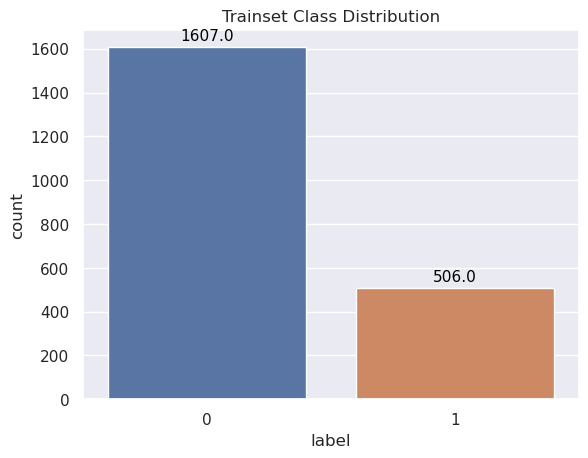

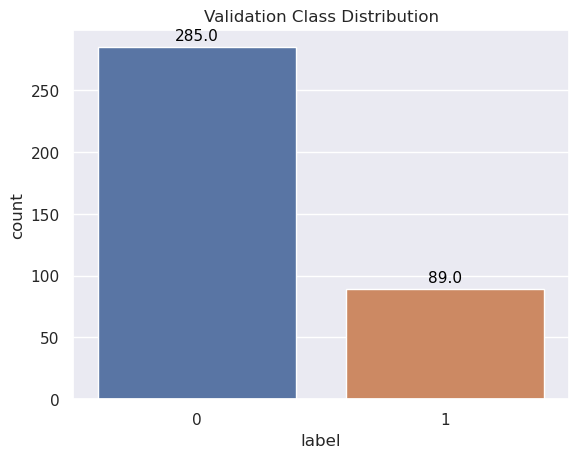

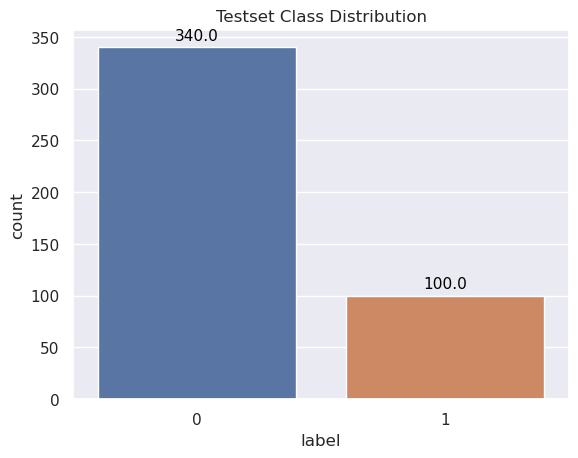

In [53]:
#split the dataset
df_train, df_test, df_validation = split_plot_dataset(dataset)

In [54]:
#vectorize the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(df_train, df_test, df_validation)

## Random Over-sampling
RandomOverSampler will increase the data samples in the minority class (vishing). It makes the minority class have the same data samples as the majority class (non-vishing).

In [55]:
from imblearn.over_sampling import RandomOverSampler
# Apply RandomOverSampler
sampling = RandomOverSampler(random_state=42) #sampling_strategy parameter is to balance the class to have 1:1 data samples

#resampling the dataset
# X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

-- Dataset shape --
Original dataset shape
Counter({0: 1607, 1: 506})
Resampled dataset shape Counter({1: 1607, 0: 1607})

DecisionTreeClassifier_RandomOverSampler

Training time: 0.347sec
Prediction time (train): 0.006sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.7364 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.98      0.67      0.80       340
           1       0.46      0.95      0.62       100

    accuracy                           0.74       440
   macro avg       0.72      0.81      0.71       440
weighted avg       0.86      0.74      0.76       440


-- Confusion matrix --
 [[229 111]
 [  5  95]]
True Positives(TP) =  229
True Negatives(TN) =  95
False Positives(FP) =  111
False Negatives(FN) =  5
--------------------------------------------------------------------------------
Accuracy :0.7363636363636363
Precision

In [56]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050
DecisionTreeClassifier_RandomOverSampler,0.620915,0.461165,0.95,0.811765,0.736364,0.346756,0.000577
RandomForestClassifier_RandomOverSampler,0.929293,0.938776,0.92,0.981882,0.968182,0.930522,0.008704
XGBClassifier_RandomOverSampler,0.564706,0.400000,0.96,0.776897,0.663636,0.705180,0.001476
LGBMClassifier_RandomOverSampler,0.557471,0.391129,0.97,0.820059,0.650000,0.399436,0.001057


## SMOTE Over-sampling method

In [57]:
from imblearn.over_sampling import SMOTE, KMeansSMOTE , ADASYN,SVMSMOTE,KMeansSMOTE,BorderlineSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.metrics import classification_report_imbalanced

In [58]:
#split the dataset
# df_train, df_test, df_validation = split_plot_dataset(dataset)

In [59]:
#vectorize the dataset
# X_train, X_validation, X_test, y_train, y_validation, y_test = vectorize_dataset(df_train, df_test, df_validation)

In [60]:
# over-sampling using SMOTE.
sampling = SMOTE(random_state=42)

#set the evaluation set for early stop models
# eval_set = [(X_validation, y_validation)]

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

-- Dataset shape --
Original dataset shape
Counter({0: 1607, 1: 506})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87d932bf40>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Resampled dataset shape Counter({1: 1607, 0: 1607})

DecisionTreeClassifier_SMOTE

Training time: 1.028sec
Prediction time (train): 0.007sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.7068 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       340
           1       0.32      0.26      0.29       100

    accuracy                           0.71       440
   macro avg       0.56      0.55      0.55       440
weighted avg       0.69      0.71      0.70       440


-- Confusion matrix --
 [[285  55]
 [ 74  26]]
True Positives(TP) =  285
True Negatives(TN) =  26
False Positives(FP) =  55
False Negatives(FN) =  74
--------------------------------------------------------------------------------
Accuracy :0.7068181818181818
Precision :0.32098765432098764
Recall :0.26
F1_score :0.287292817679558
F05_score :0.306603

In [61]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050
DecisionTreeClassifier_RandomOverSampler,0.620915,0.461165,0.95,0.811765,0.736364,0.346756,0.000577
RandomForestClassifier_RandomOverSampler,0.929293,0.938776,0.92,0.981882,0.968182,0.930522,0.008704
XGBClassifier_RandomOverSampler,0.564706,0.400000,0.96,0.776897,0.663636,0.705180,0.001476
LGBMClassifier_RandomOverSampler,0.557471,0.391129,0.97,0.820059,0.650000,0.399436,0.001057
DecisionTreeClassifier_SMOTE,0.287293,0.320988,0.26,0.549118,0.706818,1.027983,0.001831
RandomForestClassifier_SMOTE,0.885572,0.881188,0.89,0.985868,0.947727,1.181271,0.009666


## Adaptive Synthetic (ADASYN) method

In [62]:
# over-sampling using SMOTE.
sampling = ADASYN(random_state=42)

#set the evaluation set for early stop models
# eval_set = [(X_validation, y_validation)]

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

-- Dataset shape --
Original dataset shape
Counter({0: 1607, 1: 506})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87d926dc60>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Resampled dataset shape Counter({1: 1608, 0: 1607})

DecisionTreeClassifier_ADASYN

Training time: 0.773sec
Prediction time (train): 0.008sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.7068 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       340
           1       0.25      0.14      0.18       100

    accuracy                           0.71       440
   macro avg       0.51      0.51      0.50       440
weighted avg       0.66      0.71      0.68       440


-- Confusion matrix --
 [[297  43]
 [ 86  14]]
True Positives(TP) =  297
True Negatives(TN) =  14
False Positives(FP) =  43
False Negatives(FN) =  86
--------------------------------------------------------------------------------
Accuracy :0.7068181818181818
Precision :0.24561403508771928
Recall :0.14
F1_score :0.17834394904458598
F05_score :0.213

In [63]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050
DecisionTreeClassifier_RandomOverSampler,0.620915,0.461165,0.95,0.811765,0.736364,0.346756,0.000577
RandomForestClassifier_RandomOverSampler,0.929293,0.938776,0.92,0.981882,0.968182,0.930522,0.008704
XGBClassifier_RandomOverSampler,0.564706,0.400000,0.96,0.776897,0.663636,0.705180,0.001476
LGBMClassifier_RandomOverSampler,0.557471,0.391129,0.97,0.820059,0.650000,0.399436,0.001057
DecisionTreeClassifier_SMOTE,0.287293,0.320988,0.26,0.549118,0.706818,1.027983,0.001831
RandomForestClassifier_SMOTE,0.885572,0.881188,0.89,0.985868,0.947727,1.181271,0.009666


## KMeansSMOTE method
KMeans clustering before to over-sample using SMOTE.

In [64]:
# over-sampling using SMOTE.
sampling = KMeansSMOTE(random_state=42)

#set the evaluation set for early stop models
# eval_set = [(X_validation, y_validation)]

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87d92b0ca0>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda

-- Dataset shape --
Original dataset shape
Counter({0: 1607, 1: 506})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87d92b0dc0>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Resampled dataset shape Counter({1: 1608, 0: 1607})

DecisionTreeClassifier_KMeansSMOTE

Training time: 1.173sec
Prediction time (train): 0.031sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.6932 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       340
           1       0.30      0.26      0.28       100

    accuracy                           0.69       440
   macro avg       0.54      0.54      0.54       440
weighted avg       0.68      0.69      0.69       440


-- Confusion matrix --
 [[279  61]
 [ 74  26]]
True Positives(TP) =  279
True Negatives(TN) =  26
False Positives(FP) =  61
False Negatives(FN) =  74
--------------------------------------------------------------------------------
Accuracy :0.6931818181818182
Precision :0.2988505747126437
Recall :0.26
F1_score :0.27807486631016043
F05_score :0

In [65]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050
DecisionTreeClassifier_RandomOverSampler,0.620915,0.461165,0.95,0.811765,0.736364,0.346756,0.000577
RandomForestClassifier_RandomOverSampler,0.929293,0.938776,0.92,0.981882,0.968182,0.930522,0.008704
XGBClassifier_RandomOverSampler,0.564706,0.400000,0.96,0.776897,0.663636,0.705180,0.001476
LGBMClassifier_RandomOverSampler,0.557471,0.391129,0.97,0.820059,0.650000,0.399436,0.001057
DecisionTreeClassifier_SMOTE,0.287293,0.320988,0.26,0.549118,0.706818,1.027983,0.001831
RandomForestClassifier_SMOTE,0.885572,0.881188,0.89,0.985868,0.947727,1.181271,0.009666


## Borderline SMOTE method

In [66]:
# over-sampling using SMOTE.
sampling = BorderlineSMOTE(random_state=42)

#set the evaluation set for early stop models
# eval_set = [(X_validation, y_validation)]

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

-- Dataset shape --
Original dataset shape
Counter({0: 1607, 1: 506})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87d92b11b0>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Resampled dataset shape Counter({0: 1607, 1: 506})

DecisionTreeClassifier_BorderlineSMOTE

Training time: 0.886sec
Prediction time (train): 0.004sec
Prediction time (test): 0.002sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.7114 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       340
           1       0.32      0.23      0.27       100

    accuracy                           0.71       440
   macro avg       0.55      0.54      0.54       440
weighted avg       0.68      0.71      0.69       440


-- Confusion matrix --
 [[290  50]
 [ 77  23]]
True Positives(TP) =  290
True Negatives(TN) =  23
False Positives(FP) =  50
False Negatives(FN) =  77
--------------------------------------------------------------------------------
Accuracy :0.7113636363636363
Precision :0.3150684931506849
Recall :0.23
F1_score :0.26589595375722547
F05_score

In [67]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050
DecisionTreeClassifier_RandomOverSampler,0.620915,0.461165,0.95,0.811765,0.736364,0.346756,0.000577
RandomForestClassifier_RandomOverSampler,0.929293,0.938776,0.92,0.981882,0.968182,0.930522,0.008704
XGBClassifier_RandomOverSampler,0.564706,0.400000,0.96,0.776897,0.663636,0.705180,0.001476
LGBMClassifier_RandomOverSampler,0.557471,0.391129,0.97,0.820059,0.650000,0.399436,0.001057
DecisionTreeClassifier_SMOTE,0.287293,0.320988,0.26,0.549118,0.706818,1.027983,0.001831
RandomForestClassifier_SMOTE,0.885572,0.881188,0.89,0.985868,0.947727,1.181271,0.009666


## SMOTE and cleaning using ENN method

In [68]:
# over-sampling using SMOTE.
sampling = SMOTEENN(random_state=42)

#set the evaluation set for early stop models
# eval_set = [(X_validation, y_validation)]

#train the models
df_results = train_models_sampling(models, es_models, X_train, y_train, eval_set, X_test, y_test, sampling)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87d92b1510>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


-- Dataset shape --
Original dataset shape
Counter({0: 1607, 1: 506})


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f87d92b1750>
Traceback (most recent call last):
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/mbmk92/anaconda3/envs/dltest/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _Threadpool

Resampled dataset shape Counter({1: 1607, 0: 1518})

DecisionTreeClassifier_SMOTEENN

Training time: 1.203sec
Prediction time (train): 0.01sec
Prediction time (test): 0.001sec

-- Check for Overfitting --
Train set score: 1.0000 sec 
Test set score: 0.6636 sec
Prediction time (test): 0.001sec

-- classification Report --
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       340
           1       0.24      0.22      0.23       100

    accuracy                           0.66       440
   macro avg       0.51      0.51      0.51       440
weighted avg       0.65      0.66      0.66       440


-- Confusion matrix --
 [[270  70]
 [ 78  22]]
True Positives(TP) =  270
True Negatives(TN) =  22
False Positives(FP) =  70
False Negatives(FN) =  78
--------------------------------------------------------------------------------
Accuracy :0.6636363636363637
Precision :0.2391304347826087
Recall :0.22
F1_score :0.22916666666666666
F05_score :0.235

In [69]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050
DecisionTreeClassifier_RandomOverSampler,0.620915,0.461165,0.95,0.811765,0.736364,0.346756,0.000577
RandomForestClassifier_RandomOverSampler,0.929293,0.938776,0.92,0.981882,0.968182,0.930522,0.008704
XGBClassifier_RandomOverSampler,0.564706,0.400000,0.96,0.776897,0.663636,0.705180,0.001476
LGBMClassifier_RandomOverSampler,0.557471,0.391129,0.97,0.820059,0.650000,0.399436,0.001057
DecisionTreeClassifier_SMOTE,0.287293,0.320988,0.26,0.549118,0.706818,1.027983,0.001831
RandomForestClassifier_SMOTE,0.885572,0.881188,0.89,0.985868,0.947727,1.181271,0.009666


In [70]:
df_results

,F1_score,Precision,Recall,ROC AUC,Accuracy,Training time,Test time
DecisionTreeClassifier_,0.279330,0.316456,0.25,0.545588,0.706818,0.967479,0.001024
RandomForestClassifier_,0.861244,0.825688,0.90,0.965294,0.934091,0.764570,0.008661
XGBClassifier_,0.658915,0.537975,0.85,0.863868,0.800000,0.939583,0.001479
LGBMClassifier_,0.623482,0.523810,0.77,0.838779,0.788636,1.216483,0.001050
DecisionTreeClassifier_RandomOverSampler,0.620915,0.461165,0.95,0.811765,0.736364,0.346756,0.000577
RandomForestClassifier_RandomOverSampler,0.929293,0.938776,0.92,0.981882,0.968182,0.930522,0.008704
XGBClassifier_RandomOverSampler,0.564706,0.400000,0.96,0.776897,0.663636,0.705180,0.001476
LGBMClassifier_RandomOverSampler,0.557471,0.391129,0.97,0.820059,0.650000,0.399436,0.001057
DecisionTreeClassifier_SMOTE,0.287293,0.320988,0.26,0.549118,0.706818,1.027983,0.001831
RandomForestClassifier_SMOTE,0.885572,0.881188,0.89,0.985868,0.947727,1.181271,0.009666
